# CE-40719: Deep Learning
## HW6 - Deep Reinforcement Learning

(30 points)

#### Name: Sadroddin Barikbin
#### Student No.: 98208824


In this assignment we are going to design an agent to play atari game. We use a Deep Q-Network model as agent to play game Pong(`PongNoFrameskip-v4` environment of [gym](https://gym.openai.com/) library).
In this environment, the observation is an RGB image of the screen, which is an array of shape (210, 160, 3). And action space is 6.
We will train the model for 200,000 steps and should take approximately 2 hour. 
**If you train the model for 800,000 steps and achieve a score more than 10 in average in your last 10 games, you get a bonus point.**

![Pong](https://cdn-images-1.medium.com/max/800/1*UHYJE7lF8IDZS_U5SsAFUQ.gif)


 ## 1. Setup

First, we need to install `stable-baselines`. This library  is a set of improved implementations of Reinforcement Learning (RL) algorithms based on OpenAI Baselines. We will use some of **wrappers** of this library. Wrappers will allow us to add functionality to environments, such as modifying observations and rewards to be fed to our agent. It is common in reinforcement learning to preprocess observations in order to make them more easy to learn from. 

- For linux based Operating Systems or google colab run cell below:

In [ ]:
%%shell

sudo apt-get update && sudo apt-get install cmake libopenmpi-dev zlib1g-dev

pip install stable-baselines[mpi]==2.8.0

Hit:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic/main Sources [1,832 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Get:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Rel

- For Windows: 
    - First install [MPI for Windows](https://www.microsoft.com/en-us/download/details.aspx?id=57467) (you need to download and install `msmpisetup.exe`)
    - Then run this command in Prompt: `pip install stable-baselines[mpi]==2.8.0`

### 1.1. Import Libraries:

In [ ]:
import random, pickle, os.path, math, glob, csv
import numpy as np

from timeit import default_timer as timer
from datetime import timedelta

import matplotlib
%matplotlib inline
from IPython.display import clear_output
from plot import plot_all_data 

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# ######################## #
# USE ONLY IN GOOGLE COLAB #
%tensorflow_version 1.x 
# ######################## #

import gym
from gym.spaces.box import Box
from stable_baselines import bench
from stable_baselines.common.atari_wrappers import make_atari, wrap_deepmind




 ### 1.2. Hyperparameters

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Epsilon variables for epsilon-greedy:
epsilon_start    = 1.0
epsilon_final    = 0.01
epsilon_decay    = 30000
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay) 

# Misc agent variables
GAMMA = 0.99 
LR    = 5e-5

# Memory
TARGET_NET_UPDATE_FREQ = 1000 
EXP_REPLAY_SIZE        = 100000 
BATCH_SIZE             = 256

# Learning control variables
LEARN_START = 10000
MAX_FRAMES  = 800000 # Probably takes about an hour training. You can increase it if you have time!
UPDATE_FREQ = 1 

# Data logging parameters
ACTION_SELECTION_COUNT_FREQUENCY = 1000 


## 2. Model (22 Points)
We will implement a DQN model with experience replay. We implement a class for experience replay  `ExperienceReplayMemory`, for extarct features of observed picture of game we implement a class `DQN` that uses a CNN and inheritance from `nn.Module`. We implemented a wrapper class `WrapPyTorch` that you will use it in training loop.

### 2.1. Replay Memory (3 Points)

In [ ]:
#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# complete push and sample methods.
#################################################################################
class ExperienceReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []

    def push(self, transition):
        if len(self.memory)>=self.capacity:
          self.memory=self.memory[1:]+[transition]
        else:
          self.memory+=[transition]

    def sample(self, batch_size):
        return list(random.choices(self.memory,k=batch_size))

    def __len__(self):
        return len(self.memory)
#################################################################################
#                                   THE END                                     #
#################################################################################  

### 2.2. Network Declaration (4 Points)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(DQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # Initialize CNN Model :
        # conv1: out_channels:32, kernel_size=8, stride=4
        # conv2: out_channels:64, kernel_size=4, stride=2
        # conv3: out_channels:64, kernel_size=3, stride=1
        # fc1(512)
        # fc2(512)
        #################################################################################
        self.conv1=nn.Conv2d(1,32,8,stride=4)#=> 32x20x20
        self.conv2=nn.Conv2d(32,64,4,stride=2)#=>64x9x9
        self.conv3=nn.Conv2d(64,64,3,stride=1)#=>64x7x7
        self.flat=nn.Flatten()
        self.fc1=nn.Linear(64*7*7,512)
        self.fc2=nn.Linear(512,num_actions)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def forward(self, x):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # complete forward pass using initialized CNN Model. use Relu activation function 
        # for conv1, conv2, conv3, and fc1.  
        #################################################################################
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=F.relu(self.conv3(x))
        x=self.flat(x)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
        #################################################################################
        #                                   THE END                                     #
        #################################################################################   



### 2.3. Wrapper


In [ ]:
class WrapPyTorch(gym.ObservationWrapper):
    def __init__(self, env=None):
        super(WrapPyTorch, self).__init__(env)
        obs_shape = self.observation_space.shape
        self.observation_space = Box(
            self.observation_space.low[0, 0, 0],
            self.observation_space.high[0, 0, 0],
            [obs_shape[2], obs_shape[1], obs_shape[0]],
            dtype=self.observation_space.dtype)

    def observation(self, observation):
        return observation.transpose(2, 0, 1)

 ### 2.4. Agent (15 Points)

In [ ]:
class Model():
    def __init__(self, env=None, log_dir='tmp/gym'):
        self.device = device

        self.gamma = GAMMA 
        self.lr = LR
        self.target_net_update_freq = TARGET_NET_UPDATE_FREQ
        self.experience_replay_size = EXP_REPLAY_SIZE
        self.batch_size = BATCH_SIZE
        self.learn_start = LEARN_START
        self.update_freq = UPDATE_FREQ
        self.log_dir = log_dir
        self.rewards = []
        self.action_log_frequency = ACTION_SELECTION_COUNT_FREQUENCY
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # do followings line by line:
        # * make a list of action selections
        # * use shape of observation space to save number of features
        # * save naumber of actions
        # * save environment in self.env
        # * use DQN class to declare model and target model (the game is 2-player game, so
        #   we declare 2 model)
        # * using load_state_dict, share learnable parameters (i.e. weights and biases) of
        #   self.model with self.target_model 
        # * use Adam optimizer
        #################################################################################
        self.action_selections = [0.]*6
        self.num_feats = env.observation_space
        self.num_actions = 6
        self.env = env

        self.model = DQN(self.num_feats,self.num_actions)
        self.target_model = DQN(self.num_feats,self.num_actions)
            
        self.target_model.load_state_dict(self.model.state_dict())

        self.optimizer = optim.Adam(self.model.parameters(),self.lr)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

        # Move to correct device
        self.model = self.model.to(self.device)
        self.target_model.to(self.device)

        self.model.train()
        self.target_model.train()

        self.update_count = 0

        self.memory = ExperienceReplayMemory(self.experience_replay_size)
        

    def prep_minibatch(self):
      
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # random transition batch is taken from experience replay memory
        # do followings line by line:
        # * sample from self.memory with batch size, and save result in transitions, 
        #   indices, weights
        # * use transitions to save batch_state, batch_action, batch_reward, 
        #   batch_next_state as tensors
        # * save non_final_mask,  non_final_next_states as tensors, note that sometimes 
        #   all next states are false
        #################################################################################
        indices, weights = None,None
        transitions=self.memory.sample(self.batch_size)

        batch_state = torch.cat([t[0] for t in transitions])
        batch_action = torch.tensor([t[1] for t in transitions],device=device)
        batch_reward = torch.tensor([t[2] for t in transitions],device=device,dtype=torch.float32)
        batch_next_state= torch.cat([torch.tensor(t[3],dtype=torch.float32,device=device).unsqueeze(dim=0) if t[3] is not None else torch.zeros(t[0].shape,dtype=torch.float32,device=device) for t in transitions])
        non_final_mask = torch.tensor([0. if t[3] is None else 1. for t in transitions])

        try: 
            non_final_next_states = torch.cat([t[3].unsqueeze(dim=0) for t in transitions if t[3] is not None])
            empty_next_state_values = False
        except:
            non_final_next_states = None
            empty_next_state_values = True
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights

    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement calculation of loss (you can use "with torch.no_grad():")
        #################################################################################
        Qs=self.model(batch_state)
        if empty_next_state_values:
          loss=F.mse_loss(Qs[torch.arange(0,batch_state.size(0),device=device),batch_action],batch_reward)
        else:
          Qsp=self.get_max_next_state_action(non_final_next_states).detach()
          non_final_state_index=0
          loss=0.
          for i in range(batch_state.size(0)):
            if non_final_mask[i]:
              loss+=F.mse_loss(Qs[i],batch_reward[i]+self.gamma*Qsp[non_final_state_index])
              non_final_state_index+=1
            else:
              loss+=F.mse_loss(Qs[i],batch_reward[i])
          loss/=float(batch_state.size(0))
        #################################################################################
        #                                   THE END                                     #
        #################################################################################
        return loss

    def update(self, s, a, r, s_, frame=0):
        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################
        # implement update method to optimize model 
        # * push state, action, reward and new state to memoty
        # * note that if frame is lower than self.learn_start or frame % self.update_freq != 0
        #   return None
        # * take a random transition batch and compute loss
        # * optimize the model
        #################################################################################
        self.memory.push((s,a,r,s_))
        if frame<self.learn_start or frame%self.update_freq!=0:
          return None
        self.model.zero_grad()
        loss=self.compute_loss(self.prep_minibatch())
        loss.backward()
        self.optimizer.step()
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

        self.update_target_model()       
        self.save_td(loss.item(), frame)
        self.save_sigma_param_magnitudes(frame)

    def get_action(self, s, eps=0.1):

        #################################################################################
        #                          COMPLETE THE FOLLOWING SECTION                       #
        #################################################################################  
        # implement get_action method (epsilon greedy)
        # you can use "with torch.no_grad():"
        ################################################################################# 
        with torch.no_grad():
          Qs=self.model(s)
          if np.random.rand() < eps:
            return torch.randint(self.num_actions,(s.size(0),))
          else:
            return torch.argmax(Qs,dim=1)
        #################################################################################
        #                                   THE END                                     #
        #################################################################################

    def update_target_model(self):
      # update target model:
        self.update_count+=1
        self.update_count = self.update_count % self.target_net_update_freq
        if self.update_count == 0:
            self.target_model.load_state_dict(self.model.state_dict())

    def get_max_next_state_action(self, next_states):
        return self.target_model(next_states).max(dim=1)[1].view(-1, 1)


    def save_sigma_param_magnitudes(self, tstep):
        with torch.no_grad():
            sum_, count = 0.0, 0.0
            for name, param in self.model.named_parameters():
                if param.requires_grad and 'sigma' in name:
                    sum_+= torch.sum(param.abs()).item()
                    count += np.prod(param.shape)
            
            if count > 0:
                with open(os.path.join(self.log_dir, 'sig_param_mag.csv'), 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow((tstep, sum_/count))

    def save_td(self, td, tstep):
      # save temporal difference
        with open(os.path.join(self.log_dir, 'td.csv'), 'a') as f:
            writer = csv.writer(f)
            writer.writerow((tstep, td))

    def save_reward(self, reward):
        self.rewards.append(reward)

    def save_action(self, action, tstep):
        self.action_selections[int(action)] += 1.0/self.action_log_frequency
        if (tstep+1) % self.action_log_frequency == 0:
            with open(os.path.join(self.log_dir, 'action_log.csv'), 'a') as f:
                writer = csv.writer(f)
                writer.writerow(list([tstep]+self.action_selections))
            self.action_selections = [0 for _ in range(len(self.action_selections))]



 ## 3. Training Loop (8 Points)

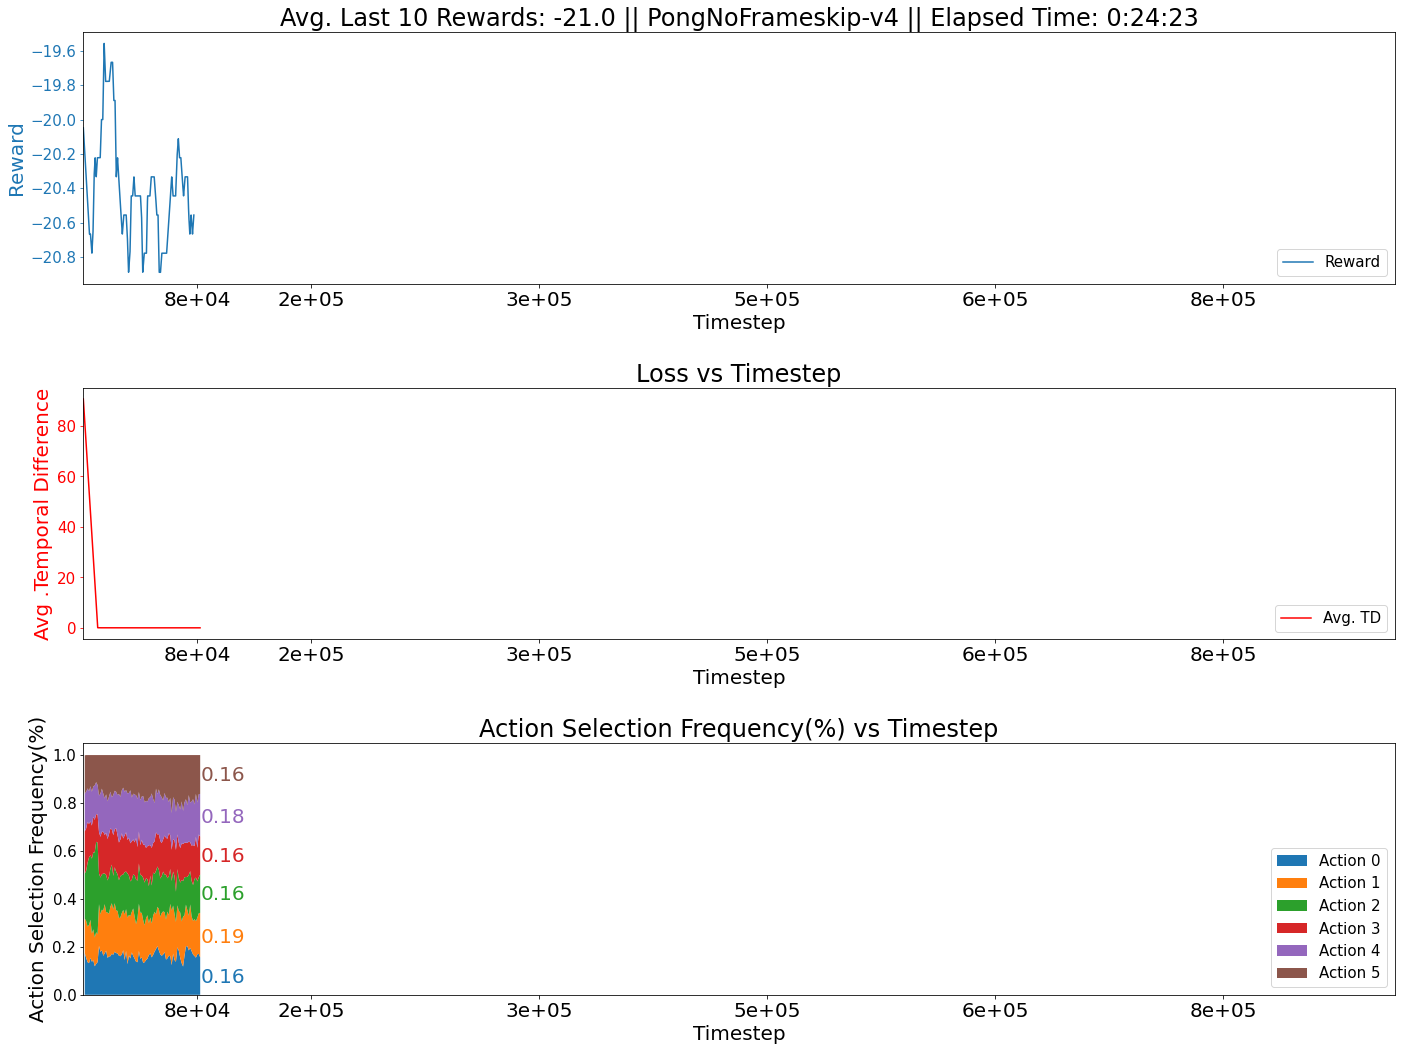

KeyboardInterrupt: ignored

In [ ]:
start=timer()

log_dir = "tmp/gym/"
try:
    os.makedirs(log_dir)
except OSError:
    files = glob.glob(os.path.join(log_dir, '*.monitor.csv')) \
        + glob.glob(os.path.join(log_dir, '*td.csv')) \
        + glob.glob(os.path.join(log_dir, '*sig_param_mag.csv')) \
        + glob.glob(os.path.join(log_dir, '*action_log.csv'))
    for f in files:
        os.remove(f)

#################################################################################
#                          COMPLETE THE FOLLOWING SECTION                       #
#################################################################################
# do followings line by line:
# * use "make_atari" wrapper and save "PongNoFrameskip-v4" game to env
# * use "bench.Monitor" wrapper to know the episode reward, length, time and other data.
# * use "wrap_deepmind" wrapper to configure environment for DeepMind-style Atari.
# * use *WrapPyTorch*
# * save model
# * implement training loop
#################################################################################
env_id = "PongNoFrameskip-v4"
env =  WrapPyTorch(wrap_deepmind(bench.Monitor(make_atari(env_id),os.path.join(log_dir,'monitor'))))

model  = Model(env)

episode_reward = 0
observation = env.reset()
for frame_idx in range(1, MAX_FRAMES + 1):
    epsilon = epsilon_by_frame(frame_idx)
    observation=torch.tensor(observation,dtype=torch.float32,device=device).unsqueeze(dim=0)
    action = model.get_action(observation,eps=epsilon)
    
    model.save_action(action, frame_idx) #log action selection

    prev_observation = observation
    observation, reward, done, _ = env.step(action)
    episode_reward+=reward

    model.update(prev_observation,action,reward,None if done else observation,frame=frame_idx)

    if done:
        observation=env.reset()
        model.save_reward(episode_reward)
        episode_reward=0
        
#################################################################################
#                                   THE END                                     #
################################################################################# 
    if frame_idx % 1000 == 0:
        try:
            clear_output(True)
            plot_all_data(log_dir, env_id, 'DQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)
        except IOError:
            pass
 
env.close()
plot_all_data(log_dir, env_id, 'DQN', MAX_FRAMES, bin_size=(10, 100, 100, 1), smooth=1, time=timedelta(seconds=int(timer()-start)), ipynb=True)

![Result](result.JPG)